### Group Members:

- Giovanni Sergio Armido Parri, 16-919-144

# Assignment 4: Multi-Output Networks and Batch Processing

The goal of this exercise is to get to know some regularization techniques when implementing deep learning methods.
For this purpose, we select a dataset that contains data in different formats, some binary ($x_d \in \{-1,1\}$) and some numerical ($x_d\in \mathbb N$); and some are categorical, which we ignore for now.
As target values, this dataset contains three numerical outputs, so, $\vec t \in \mathbb R^3$ for each sample.
These target values should be approximated with a two-layer multi-output network that we will train with the $\mathcal J^{L_2}$ loss.

Remember to make use of `numpy` in the matrix calculation, e.g. `numpy.dot`, `numpy.exp`, `numpy.mean` 

## Dataset

The dataset of our choice is the Student Performance estimation dataset that was collected in Portugal in two different schools and with two different subjects, i.e., math and Portuguese (the mother tongue).
The dataset contains many different inputs such as a binary representation of the school, gender, family sizes, and alike, as well as numerical representations of age, travel time, and alcohol consumption.
The dataset also includes some categorical data, which we skip in this assignment.
See https://archive.ics.uci.edu/ml/datasets/Student+Performance for more information on the dataset.
As a start, we will rely on the Portuguese performance (`"por"`), but you can also try to use the Math samples (`"mat"`).

### Task 1: Dataset Loading


Load the dataset from files and provide the input matrix $\mathbf X \in \mathbb R^{(D+1)\times N}$ and the output matrix $\mathbf T \in \mathbb R^{O\times N}$.

Due to the difficulty of the task, most of the implementation is provided.
The implementation is very literal and, therefore, hopefully readable, while maybe not the most efficient.

We skip categorical inputs (indexes 8-11) for now.
All other entries are converted either into binary $(-1,1)$ or into an integer range $(0,1,\ldots)$.
The three outputs range between 0 and 20 each. The bias value for $x_0=1$ is also already included.
You just need to make sure that the data $(X,T)$ is returned in the desired format.

In [1]:
import math
import numpy
import os
import random

# Dataset origin: https://archive.ics.uci.edu/ml/datasets/Student+Performance

def dataset(course="por"):
  # load dataset and provide input and target data
  # possible data files are "mat" and "por"

  # download data file from URL
  dataset_zip_file = "student.zip"
  if not os.path.exists(dataset_zip_file):
    import urllib.request
    urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip", dataset_zip_file)
    print ("Downloaded datafile", dataset_zip_file)

  import zipfile
  import csv
  import io

  # collect inputs
  inputs = []
  targets = []
  # some default values: yes=1, no=-1
  yn = {"yes":1.,"no":-1.}
  # read through dataset (without actually unzippiung to a file):
  # ... open zip file
  zip = zipfile.ZipFile(dataset_zip_file)
  # ... open data file inside of zip file and convert bytes to text
  datafile = io.TextIOWrapper(zip.open(os.path.join(F"student-{course}.csv"), 'r'))
  # ... read through the lines via CSV reader, using the correct delimiter
  reader = csv.reader(datafile, delimiter=";")
  # ... skip header line
  next(reader)
  for splits in reader:
    # read input values
    inputs.append([
      1.,                             #### BIAS ####
      {"GP":1.,"MS":-1.}[splits[0]],  # school
      {"M":1.,"F":-1.}[splits[1]],    # gender
      float(splits[2]),               # age
      {"U":1.,"R":-1.}[splits[3]],    # address
      {"LE3":1.,"GT3":-1.}[splits[4]],# family size
      {"T":1.,"A":-1.}[splits[5]],    # parents living together
      float(splits[6]),               # mother education
      float(splits[7]),               # father education
      # skip categorical values
      float(splits[12]),              # travel time
      float(splits[13]),              # study time
      float(splits[14]),              # failures
      yn[splits[15]],                 # extra support
      yn[splits[16]],                 # family support
      yn[splits[17]],                 # paid support
      yn[splits[18]],                 # activities
      yn[splits[19]],                 # nursery school
      yn[splits[20]],                 # higher education
      yn[splits[21]],                 # internet
      yn[splits[22]],                 # romantic
      float(splits[23]),              # family relation
      float(splits[24]),              # free time
      float(splits[25]),              # going out
      float(splits[26]),              # workday alcohol
      float(splits[27]),              # weekend alcohol
      float(splits[28]),              # health
      float(splits[29]),              # absences
    ])

    # read targets values
    targets.append([
      float(splits[30]),              # grade for primary school
      float(splits[31]),              # grade for secondary school
      float(splits[32]),              # grade for tertiary school
    ])

  print(F"Loaded dataset with {len(targets)} samples")
  return (numpy.array(inputs).T, numpy.array(targets).T)

### Test 1: Assert Valid Outputs

This test will check the dimension of the loaded dataset, i.e. $\mathbf X\in \mathbb R^{(D+1)\times N}$ and $\mathbf T \in \mathbb R^{O\times N}$, and also assure that all target data is in the range $t\in[0,20]$.

Please make sure that your implementation can pass these tests before moving to the next task

In [2]:
X_orig, T = dataset("por")

assert numpy.all(T >= 0) and numpy.all(T <= 20)

assert X_orig.shape[0] == 27
assert T.shape[0] == 3
assert T.shape[1] == X_orig.shape[1]

Loaded dataset with 649 samples


### Task 2: Input Data Normalization (Min-Max)

Since the data is in different input regimes, we want to normalize the data.
For this purpose, we need to compute the minimum and the maximum of the data for each input dimension.
Then, we implement a function to perform the normalization of the data using the previously computed minimum and maximum. Make sure that you handle the bias neuron $x_0$ correctly. The formula for min-max normalization is provided below:

  $$\forall d >= 1\colon x_d^{\text{norm}} = \frac{x_d - \min\limits_{\vec x'\in \mathbf X^T} x_d'}{\max\limits_{\vec x'\in \mathbf X^T} x_d' - \min\limits_{\vec x'\in \mathbf X^T} x_d'}$$

In [3]:
# compute maximum and minimum over dataset
min_val = [numpy.min(x) for x in X_orig[1:,:]]
max_val = [numpy.max(x) for x in X_orig[1:,:]]
# assure to handle x_0 correctly

assert X_orig[0, 1] == numpy.ones_like(X_orig.shape[0])

def normalize(x, min_val, max_val):
  # normalize the given data with the given minimum and maximum values
  for d in range(1,len(min_val)):
    x[d,:] -= min_val[d]
    x[d,:] /= numpy.subtract(max_val,min_val)[d]
  return x

# Normalize our dataset
X = normalize(X_orig, min_val, max_val)
assert X[0, 1] == numpy.ones_like(X_orig.shape[0])



### Task 3: Batch Processing

In order to run stochastic gradient descent, we need to split our dataset into batches of a certain batch size $B$. Implement a function that turns the dataset $(\mathbf X, \mathbf T)$ into batches of a certain batch size $B$.
Implement this function as a generator function, i.e., use ``yield`` instead of ``return``.
Circulate the dataset afresh when all data is consumed, and shuffle the data in each epoch.
Make sure that you yield both the input batch and the target batch.

In [4]:
def batch(X, T, batch_size=16):
  N_batches = X.shape[1]//batch_size 
  inds = numpy.arange(X.shape[1])
  while True:
    for i in range(N_batches):
      # shuffle dataset in each epoch
      random.shuffle(inds)
      batch_indices = inds[i*batch_size:(i+1)*batch_size]
      X_batch = X[:,batch_indices]
      T_batch = T[:,batch_indices]
      yield X_batch, T_batch, (i % N_batches == 0)
    
    

### Test 2: Test your Batches

This test is to assure that your batch generation function works as expected. 
We define some test data for this purpose.
The code below checks whether your batch function returns batches with correct content, i.e., $(\vec x, \vec t)$-alignment. 
It also checks that the batches are in the correct dimensions, i.e., that $\mathbf X \in \mathbb R^{(D+1)\times B}$ and $\mathbf T \in \mathbb R^{O\times B}$.

Make sure you can pass this test before moving forward.

In [5]:
XX = numpy.array([[i] * 5 for i in range(50)]).T
TT = numpy.array([[i] for i in range(10,60)]).T

for counter, (x,t,e) in enumerate(batch(XX, TT, 16)): ## what is the 3rd output ??
  assert x.shape[0] == 5
  assert x.shape[1] == 16
  assert t.shape[0] == 1
  assert t.shape[1] == 16
  assert numpy.all(x == t-10)
  assert e == (counter % 3 == 0)
  if counter == 20: break
  

## Gradient Descent

To train a two-layer multi-output regression network, we need to implement some functions.
The network output is computed in three steps:

  * Compute network activation for a batch of inputs $\mathbf X$: $\mathbf A = \mathbf W^{(1)}\mathbf X$
  * Call the activation function element-wise: $\mathbf H = g(\mathbf A)$. Here, we rely on the logistic activation function $\sigma$. Assure that the hidden neuron bias $\mathbf H_{0,:}$ is set appropriately.
  * Compute the output $\mathbf Y$ of the batch: $\mathbf Y = \mathbf W^{(2)}\mathbf H$.

### Task 4: Multi-Output Network

Implement a multi-target network that computes the output matrix $\mathbf Y$ for a given input dataset/batch $\mathbf X$ and given parameters $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$ using `numpy` operations. 
The function should return both the output $\mathbf Y$ and the output of the hidden units $\mathbf H$ since we will need these in gradient descent. Select the logistic function $\sigma$ as the activation function.

In [6]:
def network(X, Theta):
  W1, W2 = Theta
  if len(X.shape) == 1: 
    X = X.reshape(-1, 1) 
  # compute activation
  A = numpy.dot(W1,X)
  # compute hidden unit output
  H = 1./(numpy.add(numpy.ones_like(A),numpy.exp(-A)))
  H = numpy.vstack((numpy.ones(A.shape[1]), H))
  # compute network output
  Y = numpy.dot(W2, H)
  return Y, H

### Task 5: Loss Implementation

Implement a loss function that returns the squared loss $\mathcal J^{L_2} = \frac1B \|\mathbf Y - \mathbf T\|_F^2$ for given network outputs $\mathbf Y$ and target values $\mathbf T$.
Use `numpy` or `scipy` functionality for this task.

In [7]:
def loss(Y, T):
  return 1./T.shape[1]*numpy.linalg.norm(numpy.subtract(Y,T))**2

### Task 6: Gradient Implementation

Implement a function that computes and returns the gradient for a given batch $(\mathbf X, \mathbf T)$, the given network outputs $\mathbf Y$ and $\mathbf H$ as well as current parameters $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$.
Make sure to compute the gradient with respect to both weight matrices. Remember that we have used $\sigma$ as the activation function.
Implement the function using the fast version provided in the lecture and make use of `numpy` operations.

In [8]:
def gradient(X, T, Y, H, Theta):
  W1, W2 = Theta
  B = T.shape[1]
  ONE = numpy.ones_like(H)
  # first layer gradient
  g1 = 2./B*numpy.dot(numpy.multiply(numpy.multiply(numpy.dot(W2.T, numpy.subtract(Y,T)), H), numpy.subtract(ONE, H)), X.T)
  g1 = g1[1:, :]
  # second layer gradient
  g2 = 2./B*numpy.dot(numpy.subtract(Y,T), H.T)
  return g1, g2

### Task 7: Iterative Gradient Descent


Implement gradient descent for a given number of 10'000 epochs (**not batches!**) using given initial parameters $\Theta$ and a given batch size $B$, as well as a learning rate of $\eta=0.001$.

Make use of the normalized dataset from Task 2, split into batches with the function from Task 3, the network from Task 4, the loss from Task 5, and the gradient from Task 6.

Make sure that the network output $\mathbf Y$ and the hidden unit output $\mathbf H$ are computed only once for each batch. After applying gradient descent, add an option to use momentum learning with the given parameter `mu`.
At the end of each epoch, compute and store the loss values for each batch in a list, and this list will be returned at the end.

How many iterations do we need when $B < N$? How can you know whether your current batch is the last one of the current epoch?

In [9]:
def gradient_descent(X, T, Theta, B, eta=0.001, mu=None):
  
  loss_values = []
  Theta = numpy.array(Theta, dtype=object)
  max_epochs = 10000
  OPT = [Theta, Theta]
  stop = False
  # iterate over batches
  for x,t,e in batch(X, T, batch_size=B):
    for epoch in range(1,max_epochs+1):
      # compute network output
      Y, H = network(x, OPT[epoch])
      # compute and append loss
      err = loss(Y,t)
      # compute gradient
      grad = numpy.array(gradient(x, t, Y, H, OPT[epoch]), dtype=object)
      # and apply gradient descent
      if mu is None:
        OPT_new = OPT[epoch]-eta*grad
        OPT.append(OPT_new)
      if mu is not None:
        OPT_new = OPT[epoch] - eta*grad + mu*(OPT[epoch]-OPT[epoch-1])
        OPT.append(OPT_new)
      if e:
        loss_values.append(err)
      if len(loss_values)>= max_epochs:
        stop = True
    if stop:
      break
  # return the obtained loss values at the end
  return loss_values, OPT[-1]

### Task 8: Run Gradient Descent

Select an appropriate number of hidden neurons $K$.
Instantiate the weight matrices $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$ using the Xavier method as introduced in the lecture.

Run the gradient descent three times, first as normal gradient descent, second as stochastic gradient descent with batch size $B=16$, and third with the same setup as the second but with momentum learning involved, select $\mu =0.9$.

How can you achieve this without requiring separate implementations of the ``gradient_descent`` function from Task 7?

In [15]:
K = 20
D = 26
O = 3
W1 = numpy.random.uniform(-1./numpy.sqrt(D), 1./numpy.sqrt(D), (K, D+1))
W2 = numpy.random.uniform(-1./numpy.sqrt(K), 1./numpy.sqrt(K), (O, K+1))
Theta = [W1, W2]

import copy

# run gradient descent with full dataset
#Theta1 = copy.deepcopy(Theta)
GD,Theta1 = gradient_descent(X, T, Theta, B=X.shape[1])
# run stochastic gradient descent with batches of size 16
# Theta2 = copy.deepcopy(Theta)
SGD, Theta2 = gradient_descent(X, T, Theta, B=16)
# # run stochastic gradient descent with batches of size 16 and momentum mu=0.9
# Theta3 = copy.deepcopy(Theta)
SGD_Mo, Theta3 = gradient_descent(X, T, Theta, B=16, mu=0.9)

print(numpy.subtract(Theta1, Theta3))



[array([[ 1.52092703e-02,  7.04623714e-01,  1.27843333e-01,
          1.93422697e-01,  3.16136910e-01,  5.48667088e-02,
          5.00565679e-02,  5.98690578e-01,  2.13109372e+00,
         -6.72873337e-01,  2.14296322e-01, -5.17600068e-01,
          2.89793799e-01, -3.59202822e-02,  1.11194120e-01,
         -2.04122964e+00,  3.39705213e-01,  2.18666511e-01,
         -7.64061237e-01, -9.25088604e-01,  1.79750773e-01,
         -8.63803213e-01, -9.98461008e-01,  4.28560987e-01,
         -4.69328934e-01, -3.45979120e-01,  3.49640082e-02],
        [-1.48528933e-01,  7.37703485e-01, -1.38965756e-01,
         -8.38816383e-01,  1.50185320e-01,  2.31441080e-01,
          2.69678542e-02,  2.87542053e-01,  3.90170635e-01,
         -2.46188439e-01,  6.68466392e-01, -1.48128042e+00,
         -5.67690489e-01, -1.40803602e-01, -2.34056365e-01,
          8.04833924e-02, -4.61372989e-02,  8.86333617e-01,
          1.63819591e-01, -1.79299688e-01,  3.70916642e-02,
         -2.89244207e-01, -7.71703801e-

## Evaluation

Finally, we want to evaluate how the learning process went and what the network has actually learned.
For the former, we will plot the loss values obtained during training.
For the latter, we define one specific sample of our own, and we evaluate the impact of several factors on the performance.

### Task 9: Plotting Loss Progression

To show the learning process of the networks, plot the loss values of the three gradient descent steps from Task 8 together into one plot.
Do we need to take care of something when plotting both together?

Use logarithmic axes wherever you see fit.
An exemplary loss progression plot can be found in the slides.



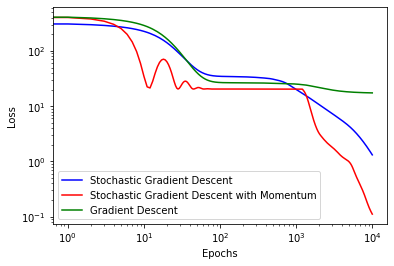

In [11]:
from matplotlib import pyplot
epochs = numpy.linspace(0, 10000, 10000)
pyplot.plot(epochs, SGD, "b-", label="Stochastic Gradient Descent")
pyplot.plot(epochs, SGD_Mo, "r-", label="Stochastic Gradient Descent with Momentum")
pyplot.plot(epochs, GD, "g-", label="Gradient Descent")
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()

### Task 10: Best and Worst Performers

We want to see what the network has learned.
Therefore, we evaluate the best student in our dataset as well as the worst student based on their average grade. 
The best student would be the one with the highest average of the 3 outputs from the model and the worst student would be the one with the lowest average of the 3 outputs from the model.
We will look into the features that represent the best student and the worst. 

Remember that input data need to be normalized before feeding it to the network. 

In [17]:
# Variables to store your info on best and worst student
best_student_idx = numpy.argmax(numpy.sum(T ,axis=0)) # Index of the top student from the dataset
worst_student_idx = numpy.argmin(numpy.sum(T ,axis=0)) # Index of the bottom student from the dataset
current_best_score = numpy.sum(T[:,best_student_idx], axis=0)/3. # Best average score of the top student
current_worst_score = numpy.sum(T[:,worst_student_idx] ,axis=0)/3. # Worst average score of the bottom student


best_pred_indx = None 
worst_pred_indx = None 
best_avarage = 0
worst_avarage = 20.

# Iterate over the whole dataset
for i, x in enumerate(X.T): 
    # compute network predictions
    prediction, _ = network(x,Theta3)

    # Take the average of the predictions
    avg = numpy.sum(prediction, axis=0)/3.
    # Check for top student. (Save their index and their average scores)
    if best_avarage < avg:
        best_avarage = avg
        best_pred_indx = i
    # Check for bottom student. (Save their index and their average scores)
    if worst_avarage > avg:
        worst_avarage = avg
        worst_pred_indx = i
print("Best student index is", best_student_idx, "with an avarage of", current_best_score)
print("The network predicts the index", best_pred_indx, "with an avarage of", best_avarage)
print("#######################")
print("Worst student index is", worst_student_idx, "with an avarage of", current_worst_score)
print("The network predicts the index", worst_pred_indx, "with an avarage of", worst_avarage)

Best student index is 338 with an avarage of 18.666666666666668
The network predicts the index 133 with an avarage of [15.25277782]
#######################
Worst student index is 567 with an avarage of 1.3333333333333333
The network predicts the index 428 with an avarage of [7.68061653]


##### Use the code below to see the features of top and bottom student in a table.

In [18]:
# Save the best and worst student featuers
best_student = X_orig[:, best_student_idx]
worst_student = X_orig[:, worst_student_idx]

# Append the average prediction in the above arrays for both students
best_student_with_score = numpy.append(best_student, current_best_score)
worst_student_with_score = numpy.append(worst_student, current_worst_score)

# This is for your visualization purpose only. It will show you the top and bottom student in a tabular format.
import pandas as pd

# Set the option to display all columns
pd.set_option('display.max_columns', None)

#Just for visualization purposes
columns = ["BIAS", "School", "Gender", "Age", "Address", "Small family", "Parents Living Together", "Mother with higher education", "Father with secondary education",
           "Travel time", "Study time", "Failures", "School Support", "Family Support", "Additional Classes", "Out-of-school activities",
           "Nursery school", "Higher education", "Internet access", "Romantic Relationship", "Good relation with family", "Free time",
           "Goes out with peers", "Workday alcohol consumption", "Weekend alcohol consumption", "Current health status",
           "Absences", "Average Score"]

# Initialize an empty DataFrame with the specified columns
df = pd.DataFrame(numpy.vstack([best_student_with_score, worst_student_with_score]), columns=columns)
df

,BIAS,School,Gender,Age,Address,Small family,Parents Living Together,Mother with higher education,Father with secondary education,Travel time,Study time,Failures,School Support,Family Support,Additional Classes,Out-of-school activities,Nursery school,Higher education,Internet access,Romantic Relationship,Good relation with family,Free time,Goes out with peers,Workday alcohol consumption,Weekend alcohol consumption,Current health status,Absences,Average Score
0,1.0,1.0,-2.285714,9.0,0.0,1.0,0.25,0.75,0.000000,0.333333,1.333333,0.5,0.0,1.0,0.0,0.0,1.0,1.0,0.0,-0.5,0.50,0.0,0.25,0.00,0.00,0.09375,0.0,18.666667
1,1.0,0.0,-2.000000,9.5,0.0,0.0,0.25,0.75,0.333333,0.000000,0.333333,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.5,0.25,0.5,0.00,0.25,0.25,0.15625,0.0,1.333333


### Task 11: Influence of Data Dimensions (Optional)


For some dimensions in the input feature $\vec x$, we want to test how different input values for this dimension would influence the outcome.
Particularly, we test:

  * Weekly study time at index $d=10$: vary in the range $[1,4]$ 
  * Past Failures at index $d=11$: vary in range $[0,3]$ 
  * Romantic relations at index $d=19$: change between yes ($1$) and no ($-1$)
  * Weekday alcohol consumption at index $d=23$: varies in the range $[1,6]$.
  * Absences at index $d=26$: vary with following values $[0,10,20,30]$.

Note that the indexes include the fact that we are omitting some input dimensions, so they might differ from what is listed on the webpage.

Check how the performance changes if the above features are changed for the best student and the worst student. 

Did the average increase or decrease? Did you expect this output?

In [19]:
# implement a way to modify the input at a given index with certain values
# and to predict and print the network output for this modification
def change_values(data,row , idx, range_type, R):
    if range_type == "cont":
        data.iloc[row, idx] = numpy.random.uniform(R[0], R[1])
    elif range_type == "disc":
        data.iloc[row, idx] = numpy.random.choice(R)
        
R = [[1,4], [0, 3], [-0.5, 0.5], [1,6], [0, 10, 20, 30]] ## romantic relations seems to be -0.5 or 0.5
style = numpy.array(["cont", "cont", "disc", "cont", "disc"])
for i,d in enumerate([10, 11, 19, 23, 26]):
    for j in range(2):
        change_values(df,j, d,style[i], R[i])
df.head()
# run this with the 5 modifications and their according to values as seen above for both top and bottom student



new_grades_best = network(df.iloc[0, 1:].values.T, Theta3)[0]
new_grades_worst = network(df.iloc[1, 1:].values.T, Theta3)[0]

print("The avarage of the best student was", current_best_score , "now is:", numpy.average(new_grades_best))
print("The avarage of the worst student was", current_worst_score , "now is:", numpy.average(new_grades_worst))

The avarage of the best student was 18.666666666666668 now is: 9.408274578775861
The avarage of the worst student was 1.3333333333333333 now is: 6.643271459249985
